In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [114]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Conv2D, Dropout, Input, MaxPool2D, GlobalAveragePooling2D, BatchNormalization, Dense
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomContrast

In [80]:
cd Google-SOL/dataset/

[WinError 3] The system cannot find the path specified: 'Google-SOL/dataset/'
C:\Users\bhand\OneDrive\Desktop\Deep Learning\Google-SOL\dataset


In [93]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32

root_dir = "C:/Users/bhand/OneDrive/Desktop/Deep Learning/Google-SOL/resources/dataset"

train_dataset = image_dataset_from_directory(directory=root_dir,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             shuffle=True,
                                             seed=101,
                                             validation_split=0.3,
                                             subset="training")

valid_dataset = image_dataset_from_directory(directory=root_dir,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             shuffle=True,
                                             seed=101,
                                             validation_split=0.3,
                                             subset="validation")

Found 792 files belonging to 2 classes.
Using 555 files for training.
Found 792 files belonging to 2 classes.
Using 237 files for validation.


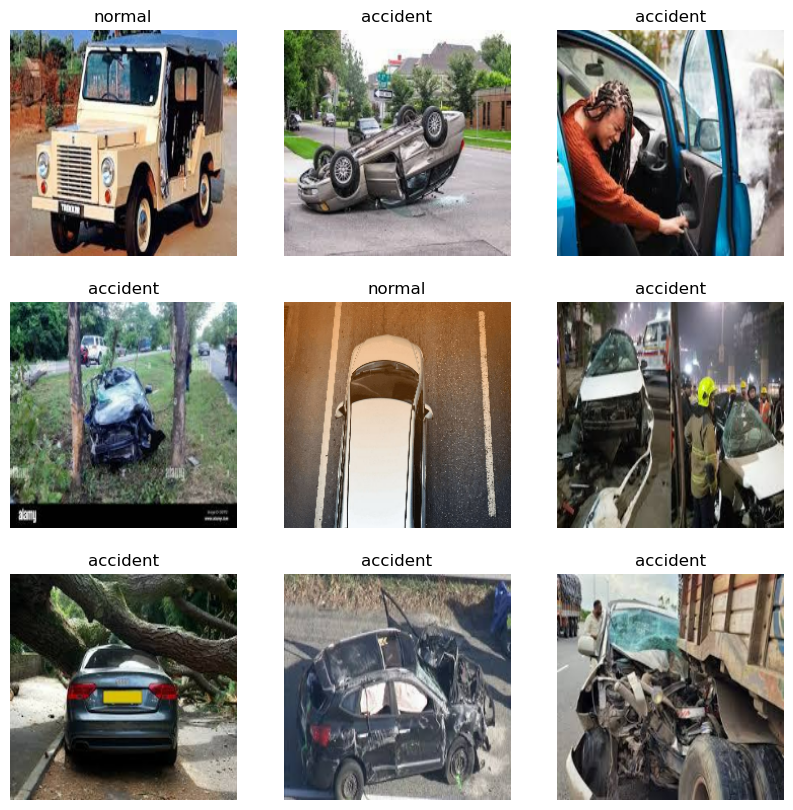

In [94]:
class_names = train_dataset.class_names

plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(100):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [95]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [105]:
def data_augmenter():
    
    data_augmentation = tf.keras.Sequential([
        RandomFlip(mode="horizontal"),
        RandomRotation(factor=0.2),
        RandomContrast(factor=0.5)
    ])
    return data_augmentation

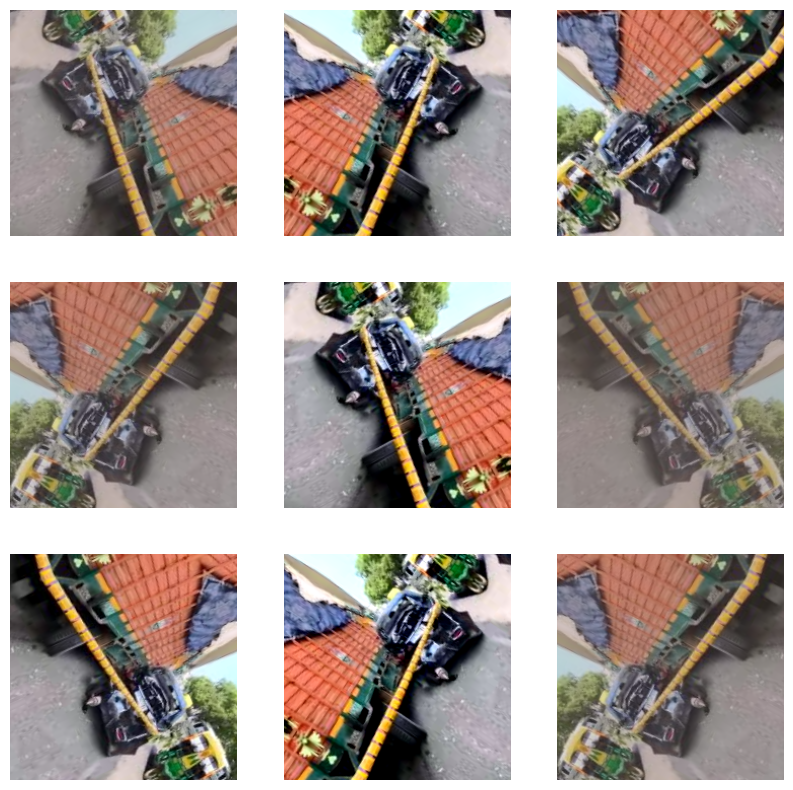

In [106]:
data_augmentation = data_augmenter()

for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10,10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        aug_image = data_augmentation(np.expand_dims(first_image,0))
        plt.imshow(aug_image[0]/255)
        plt.axis("off")

In [83]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = ResNet50(input_shape=IMG_SHAPE,include_top=True,weights='imagenet')

In [107]:
nb_layers = len(base_model.layers)
nb_layers

177

In [115]:
def cnn_model(img_size=IMG_SIZE, data_augmentation=data_augmenter()):
    
    input_shape = img_size + (3,)
    
    base_model = ResNet50(input_shape=input_shape,
                          include_top=False, 
                          weights="imagenet")
    base_model.trainable = False
    
    
    inputs = Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    
#     x = Dense(512, activation ='relu')(x)
#     x = BatchNormalization()(x)
    
    x = Dense(256, activation ='relu')(x)
    x = BatchNormalization()(x)
    
#     x = Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
    outputs = Dense(2, activation="sigmoid")(x)
    
    model = Model(inputs, outputs)
    return model

In [116]:
augmentor = data_augmenter()
model = cnn_model(IMG_SIZE, augmentor)

In [119]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=["accuracy"])

In [120]:
initial_epochs = 20
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=initial_epochs, batch_size=BATCH_SIZE)

Epoch 1/20



18/18 [==============================] - 33s 2s/step - loss: 0.7477 - accuracy: 0.7550 - val_loss: 0.3716 - val_accuracy: 0.8228
Epoch 2/20
18/18 [==============================] - 28s 2s/step - loss: 0.3033 - accuracy: 0.8937 - val_loss: 0.2697 - val_accuracy: 0.8776
Epoch 3/20
18/18 [==============================] - 36s 2s/step - loss: 0.2086 - accuracy: 0.9261 - val_loss: 0.2210 - val_accuracy: 0.9156
Epoch 4/20
18/18 [==============================] - 38s 2s/step - loss: 0.0982 - accuracy: 0.9676 - val_loss: 0.2068 - val_accuracy: 0.9283
Epoch 5/20
18/18 [==============================] - 37s 2s/step - loss: 0.1469 - accuracy: 0.9441 - val_loss: 0.2034 - val_accuracy: 0.9241
Epoch 6/20
18/18 [==============================] - 36s 2s/step - loss: 0.0801 - accuracy: 0.9784 - val_loss: 0.1907 - val_accuracy: 0.9325
Epoch 7/20
18/18 [==============================] - 36s 2s/step - loss: 0.0711 - accuracy: 0.9766 - val_loss: 0.1913 - val_accuracy: 0.9367
Epoch 8/20
18/18 [=============

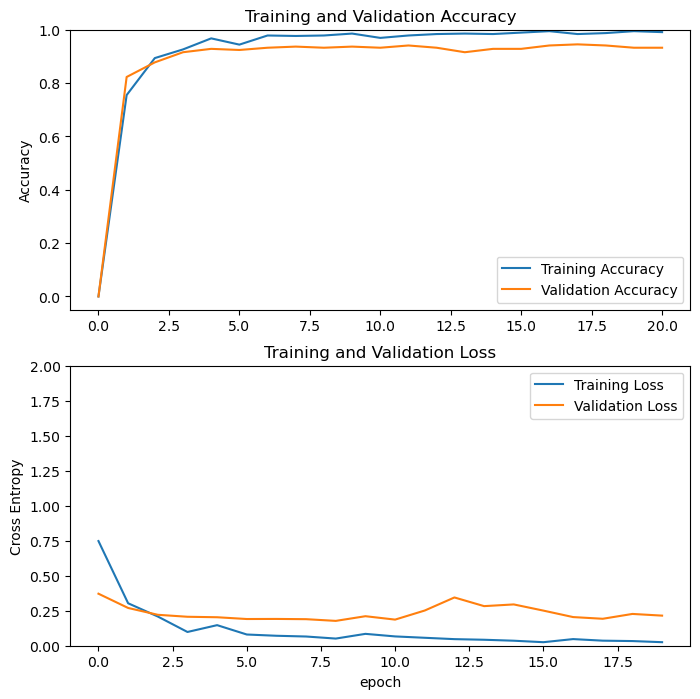

In [121]:
acc = [0.] + history.history["accuracy"]
val_acc = [0.] + history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [127]:
model.save("model.h5")

C:\Users\bhand\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
